# Comparing KWR and psKWR performance in parameter inference


Use MONOD to infer parameters on mouse data and compare the inferred parameters usng quadvec and the neural approximation method. Show that there is high correlation between the quadvec and the neural method. Timing benefits ? At least show a few? Don't worry about comparing to FQ? 


Also choose genes that are very highly expressed.


Microstate vs. grid timing? 


In [1]:
%cd /home/tara/temp_git2/GCCP_2022/figs/

/home/tara/temp_git2/GCCP_2022/figs


In [2]:
import sys,os,importlib_resources

sys.path.append('../psKWR/')
sys.path.append('../monod/src/')
sys.path.append('../monod/src/monod/')
# sys.path.append(importlib_resources.files('cme_toolbox'))

# numbers and dataloaders
import numpy as np
import scipy
import scipy.stats as stats
import torch
import pickle
from scipy.stats import pearsonr

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['font.family'] = 'Arial'
from colorama import Fore, Style

# monod
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


device = torch.device('cuda') 

## Define MONOD models

In [3]:
fitmodel_qv = cme_toolbox.CMEModel(bio_model='Bursty',seq_model='None',quad_method="quad_vec")
fitmodel_KWR = cme_toolbox.CMEModel(bio_model='Bursty',seq_model='None',quad_method="nn_10")
fitmodel_psKWR = cme_toolbox.CMEModel(bio_model='Bursty',seq_model='None',quad_method="nn_microstate")

## Load in data 

In [4]:
!wget https://github.com/pachterlab/monod_examples/raw/dev/sample_data/allen_C01_gaba.tar.gz
!wget https://github.com/pachterlab/monod_examples/raw/dev/polyA_ref/gg_200524_mouse_genome_polyA_cum_1
!tar -xvzf allen_C01_gaba.tar.gz

--2024-03-19 16:38:18--  https://github.com/pachterlab/monod_examples/raw/dev/sample_data/allen_C01_gaba.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pachterlab/monod_examples/dev/sample_data/allen_C01_gaba.tar.gz [following]
--2024-03-19 16:38:18--  https://raw.githubusercontent.com/pachterlab/monod_examples/dev/sample_data/allen_C01_gaba.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29515422 (28M) [application/octet-stream]
Saving to: ‘allen_C01_gaba.tar.gz.6’

allen_C01_gaba.tar. 100%[===================>]  28.15M   111MB/s    in 0.3s    

2024-03-19 16:38:19 (111 MB/s)

In [5]:
# dataset_meta = ['allen_B08']
dataset_meta = ['allen_C01_gaba']
dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = './gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['./'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)

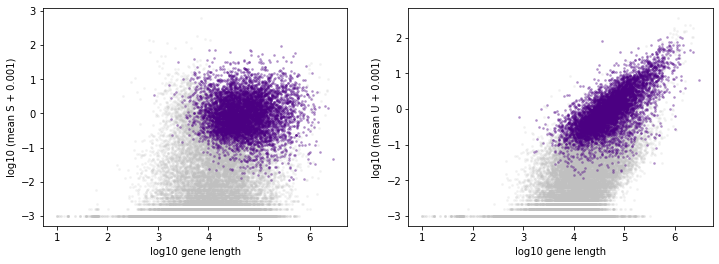

In [6]:
# !mkdir -p monod_demo_fits
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./monod_demo_fits',meta='allen_noisefree',batch_id=1,\
                                             n_genes=200,exp_filter_threshold=None,creator='gccp',datestring='nodate')


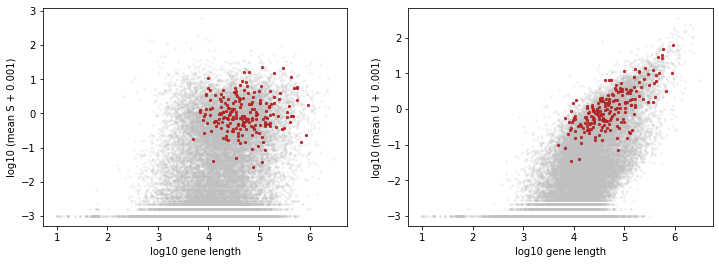

In [7]:
# define search data object
i=0
search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names)

In [8]:
# what genes are we working with?
print(search_data.gene_names)

['Serpinb8' 'Ddx18' 'Cacna1e' 'Kdsr' 'Fam163a' 'Ppp1r7' 'Adipor1' 'Lamc1'
 'Tfb2m' 'St8sia4' 'Paqr8' 'Xkr4' 'Trp53bp2' 'Spats2l' 'Snx3' 'Map7'
 'Hnrnph3' 'Rxylt1' 'Os9' 'Ptprb' 'Ankrd24' 'Mcm3ap' 'Zkscan17' 'Casc3'
 'Dhx40' 'Gga3' 'Slc36a1' 'Asb3' 'Ccng1' 'Myo19' 'Stxbp4' 'Rgs9'
 'Pafah1b1' 'Unk' 'Gas7' '0610010F05Rik' 'Atp6v0a1' 'Tsr1' 'Spred2'
 'Rnf157' 'Car4' 'Cinp' 'Ccdc88c' 'Setd3' 'Klc1' 'Rgs6' 'Rapgef5'
 'Ccdc85c' 'Ndufb1-ps' 'Gmpr' 'Ryr2' 'Atg10' 'Fgf10' 'Ankrd55'
 '4833420G17Rik' 'Lyrm4' '2810049E08Rik' 'Ankrd28' 'Tox4' 'Ubac2' 'Fermt2'
 'Cpne8' 'Lrp12' 'Slc4a8' 'Nudcd1' 'Kcnh3' 'Mgat3' '6030458C11Rik'
 'Mettl7a1' 'Ncald' 'Crkl' 'Atg3' 'Aifm3' 'Ppm1f' 'Fam131a' 'Mapk1' 'Cd47'
 'Son' 'Usp7' 'Ndufv2' 'Brd2' 'Gnptg' 'Ttc7' 'Prr3' 'Smchd1' 'Ctnna1'
 'Grpel2' 'Tcof1' 'Gm49980' 'Sptbn2' 'Il33' 'Tnks2' 'Chka' 'Rbp4' 'Chrm1'
 'Cep78' 'Ptar1' 'Pdcd11' 'Btaf1' 'Atp5c1' 'Lypd6b' 'Psmd14' 'Anapc2'
 'Arl14ep' 'Itpka' 'Atp9a' 'Immp1l' 'Pkp4' 'Golga1' 'Ncoa5' 'Lzts3'
 'Dynlrb1' 'Plpp7' 'Upf2

In [9]:
# set limits to search
search_data = monod.analysis.load_search_data(dataset_strings[0]+'/raw.sd')
result_strings = []
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]

In [10]:
# define inference parameters
i = 0

inference_parameters_qv = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_qv,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
inference_parameters_KWR = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_KWR,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
inference_parameters_psKWR = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_psKWR,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})

In [11]:
# define inference class
grad_inference_qv = monod.inference.GradientInference(inference_parameters_qv, fitmodel_qv, search_data, 0)
grad_inference_KWR = monod.inference.GradientInference(inference_parameters_KWR, fitmodel_KWR, search_data, 0)
grad_inference_psKWR = monod.inference.GradientInference(inference_parameters_psKWR, fitmodel_psKWR, search_data, 0)


-------

# Timing and inference

In [12]:
import time 
import copy
N = 200

In [13]:
# QV_large
N = 200
search_data_hf = copy.deepcopy(search_data)
search_data_hf.M[0,:] += 50
search_data_hf.M[1,:] += 50

t_qv = []
res_qv = []
for i in range(N):
    print(i)
    t1 = time.time()
    res_qv.append(grad_inference_qv.optimize_gene(i,fitmodel_qv,search_data_hf))
    t_qv.append(time.time()-t1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [14]:
# QV_small
N = 200
t_qv_small = []
res_qv_small = []
for i in range(N):
    print(i)
    t1 = time.time()
    res_qv_small.append(grad_inference_qv.optimize_gene(i,fitmodel_qv,search_data))
    t_qv_small.append(time.time()-t1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [15]:
# KWR
t_KWR = []
res_KWR = []
for i in range(N):
    print(i)
    t1 = time.time()
    res_KWR.append(grad_inference_KWR.optimize_gene(i,fitmodel_KWR,search_data))
    t_KWR.append(time.time()-t1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [16]:
# psKWR
t_psKWR = []
res_psKWR = []
for i in range(N):
    print(i)
    t1 = time.time()
    res_psKWR.append(grad_inference_psKWR.optimize_gene(i,fitmodel_psKWR,search_data))
    t_psKWR.append(time.time()-t1)

0
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting pr

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
10
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
16
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

19
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
31
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
38
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
50
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
54
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
56
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
60
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
61
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
63
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
66
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
74
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
81
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting p

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

108
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
116
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
142
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
161
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
171
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
194
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
196
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
199
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting 

## For which genes did the model perform well?

In [17]:
import scipy

def get_chisquared(search_data,gene_index,phys_optimum,model):
    
    lm = search_data.M[:, gene_index]
    expect_freq = (
                model.eval_model_pss(
                phys_optimum,
                lm,
                )
                * search_data.n_cells
            )
        
        
    counts = np.concatenate(
                    (search_data.n_cells * search_data.hist[gene_index][1], [0])
                )
    expect_freq = expect_freq[
                    search_data.hist[gene_index][0][:, 0],
                    search_data.hist[gene_index][0][:, 1],
                ]
    expect_freq = np.concatenate(
                    (expect_freq, [search_data.n_cells - expect_freq.sum()])
                )

    hellinger_ = (
                1
                / np.sqrt(2)
                * (
                    (
                        np.sqrt(expect_freq / search_data.n_cells)
                        - np.sqrt(counts / search_data.n_cells)
                    )
                    ** 2
                ).sum()
            )

    bins = []
    bin_ind = 0
    run_bin_obs = 0
    run_bin_exp = 0
    bin_obs = []
    bin_exp = []
    for i in range(len(counts)):
        bins.append(bin_ind)
        run_bin_obs += counts[i]
        run_bin_exp += expect_freq[i]
        if min(run_bin_obs, run_bin_exp) < 5:  # and i
            pass
        else:
            bin_ind += 1
            bin_obs.append(run_bin_obs)
            bin_exp.append(run_bin_exp)
            run_bin_obs = 0
            run_bin_exp = 0
    
    bins = np.asarray(bins)
    observed = np.asarray(bin_obs)
    proposed = np.asarray(bin_exp)
    observed[-1] += run_bin_obs
    proposed[-1] += run_bin_exp
    bins[bins == len(observed)] = len(observed) - 1

    for b_ in range(len(bin_obs)):
        assert np.isclose(observed[b_], counts[bins == b_].sum())
        assert np.isclose(proposed[b_], expect_freq[bins == b_].sum())
    assert np.isclose(observed.sum(), search_data.n_cells)
    assert np.isclose(proposed.sum(), search_data.n_cells)
    assert np.isclose(search_data.n_cells, counts.sum())
    assert np.isclose(search_data.n_cells, expect_freq.sum())

    csq_stat, csq_pval = scipy.stats.mstats.chisquare(
                    observed,
                    proposed,  # chisq_data, chisq_prop,
                    model.get_num_params(),
                )
    
    

    return(hellinger_,csq_stat, csq_pval)

# Plot results

In [18]:
t_qv = np.asarray(t_qv)
t_qv_small = np.asarray(t_qv_small)
t_KWR = np.asarray(t_KWR)
t_psKWR = np.asarray(t_psKWR)

pars_qv = np.asarray([x[0] for x in res_qv])
pars_qv_small = np.asarray([x[0] for x in res_qv_small])
pars_KWR = np.asarray([x[0] for x in res_KWR])
pars_psKWR = np.asarray([x[0] for x in res_psKWR])

loss_qv = np.asarray([x[1] for x in res_qv])
loss_qv_small = np.asarray([x[1] for x in res_qv_small])
loss_KWR = np.asarray([x[1] for x in res_KWR])
loss_psKWR = np.asarray([x[1] for x in res_psKWR])

In [19]:
N = 200
hellingers_qv = np.ones(200)
csq_stats_qv = np.ones(200)
csq_pvals_qv = np.ones(200)

hellingers_KWR = np.ones(200)
csq_stats_KWR = np.ones(200)
csq_pvals_KWR = np.ones(200)



for gene_index in range(N):

    hellinger_,csq_s,csq_p = get_chisquared(search_data,gene_index,phys_optimum = pars_qv[gene_index],model=fitmodel_qv)
    hellingers_qv[gene_index] = hellinger_
    csq_stats_qv[gene_index] = csq_s
    csq_pvals_qv[gene_index] = csq_p
    
    
    hellinger_,csq_s,csq_p = get_chisquared(search_data,gene_index,phys_optimum = pars_KWR[gene_index],model=fitmodel_KWR)
    hellingers_KWR[gene_index] = hellinger_
    csq_stats_KWR[gene_index] = csq_s
    csq_pvals_KWR[gene_index] = csq_p

In [20]:
thresh_h = 0.05
thresh_csq = 0.05
reject = np.array([(csq_pvals_qv[i]>thresh_csq) and (hellingers_qv[i]<thresh_h) for i in range(N)])
sum(reject)

80

In [21]:
# plotting parameters
cmap_quad = ("#3c0d03", "#8d1c06", "#e67424", "#ed9b49", "#f5c34d") #greek
cmap_ml = ( "#b86092", "#79ad41", "#4fb6ca", "#178f92", "#d7aca1") # austria, isfahan1 and isfahan2


color_KWR = cmap_ml[3]
color_qv_small = cmap_quad[4]
color_qv = cmap_quad[3]
color_psKWR = 'salmon'

color_KWR_bad = 'gray'
color_psKWR_bad = 'gray'


alf = 0.5
alf_bad = 0.1
ms = 30
psKWR_marker = 'd'
edgecolor = None
fontsize=18

<>:52: DeprecationWarning: invalid escape sequence \l
<>:53: DeprecationWarning: invalid escape sequence \l
<>:54: DeprecationWarning: invalid escape sequence \l
<>:52: DeprecationWarning: invalid escape sequence \l
<>:53: DeprecationWarning: invalid escape sequence \l
<>:54: DeprecationWarning: invalid escape sequence \l
<ipython-input-22-52e2c12ea331>:52: DeprecationWarning: invalid escape sequence \l
  ax1[0,0].set_title('Inferred $\log_{10} b$', fontsize=fontsize)
<ipython-input-22-52e2c12ea331>:53: DeprecationWarning: invalid escape sequence \l
  ax1[0,1].set_title('Inferred $\log_{10} \\beta / \\alpha$', fontsize=fontsize)
<ipython-input-22-52e2c12ea331>:54: DeprecationWarning: invalid escape sequence \l
  ax1[0,2].set_title('Inferred $\log_{10} \\gamma / \\alpha$', fontsize=fontsize)


getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob joint
getting prob

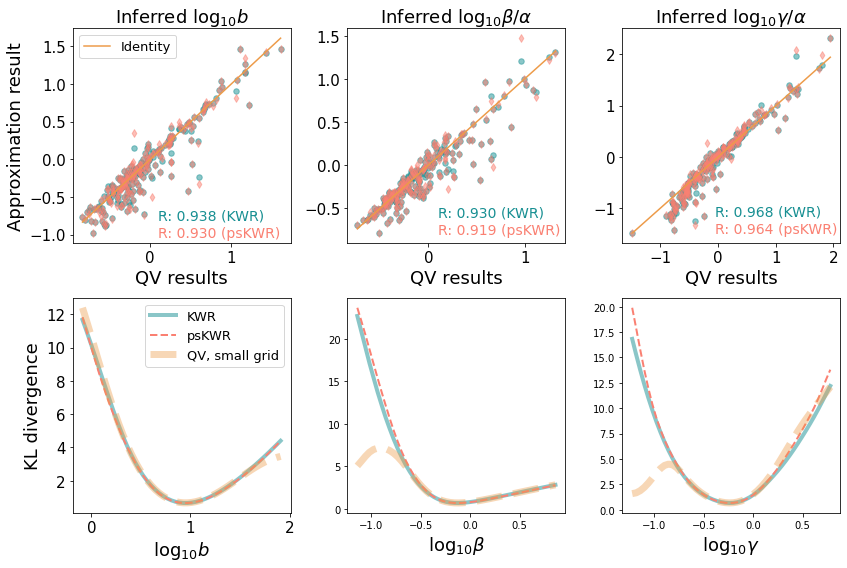

In [22]:
# maybe only choose genes which had a good model fit?? 
annot_loc = np.array([[.1,-.8],[.1,-.6],[-.05,-1.15]])
annot_space = [.23,.2,.33]
fig1,ax1=plt.subplots(2,3,figsize=(12,8))

param_names = fitmodel_KWR.get_log_name_str()

for k in range(3):
#     ax1[0,k].scatter(pars_qv[:,k],pars_qv_small[:,k],ms,color_qv_small,alpha=alf,label='QV, small grid',marker=psKWR_marker,
#                      edgecolor=edgecolor)
#     ax1[0,k].scatter(pars_qv[reject,k],pars_KWR[reject,k],ms,color_KWR,alpha=alf,label='KWR',
#                      edgecolor=edgecolor)
#     ax1[0,k].scatter(pars_qv[reject,k],pars_psKWR[reject,k],ms,color_psKWR,alpha=alf,label='psKWR',marker=psKWR_marker,
#                      edgecolor=edgecolor)
    
#     ax1[0,k].scatter(pars_qv[~reject,k],pars_KWR[~reject,k],ms,color_KWR_bad,alpha=alf_bad,
#                      edgecolor=edgecolor)
#     ax1[0,k].scatter(pars_qv[~reject,k],pars_psKWR[~reject,k],ms,color_psKWR_bad,alpha=alf_bad,
#                      marker=psKWR_marker,
#                      edgecolor=edgecolor)

    ax1[0,k].scatter(pars_qv[:,k],pars_KWR[:,k],ms,color_KWR,alpha=alf,
                     edgecolor=edgecolor)
    ax1[0,k].scatter(pars_qv[:,k],pars_psKWR[:,k],ms,color_psKWR,alpha=alf,
                     marker=psKWR_marker,
                     edgecolor=edgecolor)
    
    xl = [pars_qv[:,k].min(),pars_qv[:,k].max()]
    
    pearsonr_KWR_reject, pval_KWR_reject = pearsonr(pars_qv[:,k], pars_KWR[:,k])
    pearsonr_psKWR_reject, pval_psKWR_reject = pearsonr(pars_qv[:,k], pars_psKWR[:,k])
    
    pearsonr_KWR, pval_KWR = pearsonr(pars_qv[:,k], pars_KWR[:,k])
    pearsonr_psKWR, pval_psKWR = pearsonr(pars_qv[:,k], pars_psKWR[:,k])
#     pearsonr_qv_small, pval_qv_small = pearsonr(pars_qv[:,k], pars_qv_small[:,k])
    
    ax1[0,k].text(annot_loc[k,0], annot_loc[k,1], 
                  f'R: {pearsonr_KWR_reject:.3f} (KWR)',
                  fontsize=14, color=color_KWR)
    ax1[0,k].text(annot_loc[k,0], annot_loc[k,1]-annot_space[k], 
                  f'R: {pearsonr_psKWR_reject:.3f} (psKWR)',
                  fontsize=14, color=color_psKWR)
    ax1[0,k].plot(xl,xl,'-',color=color_qv,label='Identity')
    ax1[0,k].tick_params(labelsize=15)
    ax1[0,k].set_xlabel('QV results',fontsize=fontsize)
    

    if k == 0:
        ax1[0,k].set_ylabel('Approximation result',fontsize=fontsize)
        ax1[0,k].legend(fontsize=fontsize-5)
        
ax1[0,0].set_title('Inferred $\log_{10} b$', fontsize=fontsize)
ax1[0,1].set_title('Inferred $\log_{10} \\beta / \\alpha$', fontsize=fontsize)
ax1[0,2].set_title('Inferred $\log_{10} \\gamma / \\alpha$', fontsize=fontsize)
#         ax1[0,k].set_xscale('log')
#         ax1[0,k].set_yscale('log')
    




gind = 153
n_pts = 50
for k in range(3):
    p = pars_KWR[gind]
    domain = p[k] + np.linspace(-1,1,n_pts)
    kld_qv = []
    kld_KWR = []
    kld_psKWR = []
    kld_qv_small = []

    for d in domain:
        p_ = np.copy(p)
        p_[k] = d
        kld_qv.append(fitmodel_qv.eval_model_kld(p_, search_data_hf.M[:,gind], "None", search_data_hf.hist[gind]))
        kld_KWR.append(fitmodel_KWR.eval_model_kld(p_, search_data.M[:,gind], "None", search_data.hist[gind]))
        kld_psKWR.append(fitmodel_psKWR.eval_model_kld(p_, search_data.M[:,gind], "None", search_data.hist[gind]))
#         kld_qv_small.append(fitmodel_qv.eval_model_kld(p_, search_data.M[:,gind], "None", search_data.hist[gind]))

    ax1[1,k].plot(domain,kld_KWR,'-',color=color_KWR,label='KWR',linewidth=4,alpha=0.5)
    ax1[1,k].plot(domain,kld_psKWR,'--',color=color_psKWR,label='psKWR',linewidth=2)
    ax1[1,k].plot(domain,kld_qv,'--',color=color_qv,linewidth=7,alpha=0.4,label='QV, small grid')
#     ax1[1,k].plot(domain,kld_qv_small,linestyle='dashdot',color=color_qv_small,linewidth=1,alpha=0.4,label='QV')
    ax1[1,k].set_xlabel(param_names[k],fontsize=fontsize)
#     ax1[1,k].set_yscale('log')
    if k==0:
        ax1[1,k].legend(fontsize=fontsize-5)
        ax1[1,k].set_ylabel('KL divergence',fontsize=fontsize)
        ax1[1,k].tick_params(labelsize=15)
        

# ax1[0,0].set_title('a. Inferred log burst sizes',fontsize=fontsize)
# ax1[0,0].set_title('a. Inferred log burst sizes',fontsize=fontsize)
# ax1[0,1].set_title('b. Inferred log splicing rates',fontsize=fontsize)
# ax1[0,2].set_title('c. Inferred log degradation rates',fontsize=fontsize)
# ax1[1,0].set_title('d. Timing for three inference methods')
# ax1[1,1].set_title('e. State space size dependence for timing')
# ax1[1,2].set_title('f. Optimal KLDs for three inference methods')
# ax1[1,0].set_title('g. Burst size KLD landscape',fontsize=fontsize)
# ax1[1,1].set_title('h. Splicing rate KLD landscape',fontsize=fontsize)
# ax1[1,2].set_title('i. Degradation rate KLD landscape',fontsize=fontsize)

plt.tight_layout()
plt.savefig('./monod_inferred_parameters.png',dpi=450,bbox_inches='tight')

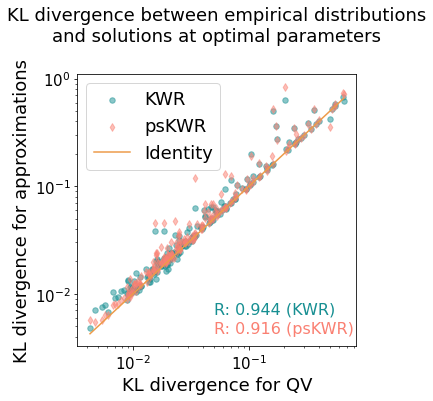

In [23]:
# plot KLDs 
fig,ax1 = plt.subplots(figsize=(5,5))
# ax1.scatter(loss_qv[~reject],loss_KWR[~reject],ms,color_KWR_bad,alpha=alf_bad,
#                  edgecolor=edgecolor)
# ax1.scatter(loss_qv[~reject],loss_psKWR[~reject],ms,color_psKWR_bad,alpha=alf_bad,
#                  marker=psKWR_marker,
#                  edgecolor=edgecolor)
# ax1.scatter(loss_qv[reject],loss_KWR[reject],ms,color_KWR,alpha=alf,label='KWR',
#                  edgecolor=edgecolor)
# ax1.scatter(loss_qv[reject],loss_psKWR[reject],ms,color_psKWR,alpha=alf,label='psKWR',
#                  marker=psKWR_marker,
#                  edgecolor=edgecolor)



ax1.scatter(loss_qv,loss_KWR,ms,color_KWR,alpha=alf,label='KWR',
                 edgecolor=edgecolor)
ax1.scatter(loss_qv,loss_psKWR,ms,color_psKWR,alpha=alf,label='psKWR',
                 marker=psKWR_marker,
                 edgecolor=edgecolor)

xl = [loss_qv.min(),loss_qv.max()]
ax1.plot(xl,xl,'-',color=color_qv,label='Identity')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=fontsize,loc='upper left')
ax1.set_xlabel('KL divergence for QV',fontsize=fontsize)
ax1.set_ylabel('KL divergence for approximations',fontsize=fontsize)
ax1.tick_params(labelsize=15)

pearsonr_KWR, pval_KWR = pearsonr(loss_qv,loss_KWR,)
pearsonr_psKWR, pval_psKWR = pearsonr(loss_qv,loss_psKWR,)

ax1.text(0.05,0.0065, f'R: {pearsonr_KWR:.3f} (KWR)', fontsize=16, color=color_KWR)
ax1.text(0.05,0.0043, f'R: {pearsonr_psKWR:.3f} (psKWR)', fontsize=16, color=color_psKWR)


plt.title('KL divergence between empirical distributions\nand solutions at optimal parameters',
         fontsize = fontsize, y = 1.1)

plt.savefig('./monod_klds.png',dpi=450,bbox_inches='tight');

# Digging into genes


Does this well capture the distributions of genes? 

In [24]:
import matplotlib as mpl

In [25]:
gene_names = search_data.gene_names

In [26]:
samp = None
gene = 'Cacna1e'
print(gene in gene_names)
i = np.where(gene_names == gene)[0][0]
print(i)

True
2


Cacna1e
[65 36]
getting prob joint
getting prob joint


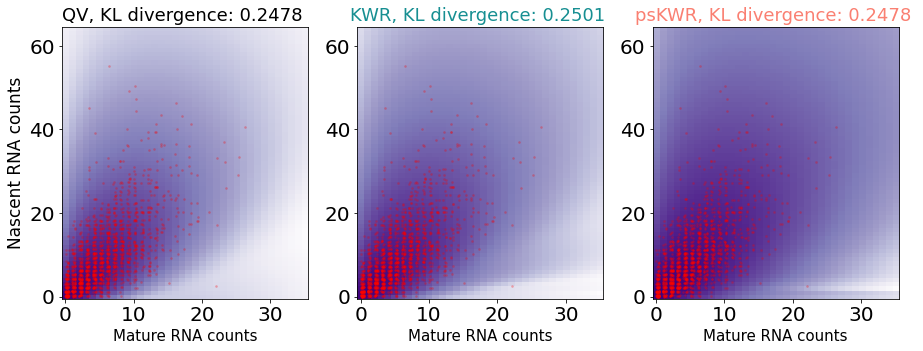

In [27]:
print(search_data.gene_names[i])
cmap = sns.cubehelix_palette(as_cmap=True,reverse=True)

cmap = mpl.colormaps['Purples']

fig,ax = plt.subplots(1,3,figsize = (15,5))
lm = search_data.M[:,i]
print(lm)
jitter = np.random.uniform(0, 0.5, size=search_data.layers[:2,i,:].shape)


# plot qv predicted distribution
y = search_data.layers[0,i,:]+jitter[0,:]
x = search_data.layers[1,i,:]+jitter[1,:]
ax[0].scatter(x,y,color='red',s=3,alpha=0.2)
qv_predicted_distribution = fitmodel_qv.eval_model_pss(pars_qv[i], lm)
ax[0].imshow(np.log10(qv_predicted_distribution),cmap = cmap,aspect="auto")
ax[0].invert_yaxis()
kld_ = fitmodel_qv.eval_model_kld(pars_psKWR[i], lm, samp, search_data.hist[i], hist_type="unique", EPS=1e-15)
ax[0].set_title(f'QV, KL divergence: {kld_:.4f} ',fontsize=fontsize)


# plot KWR predicted distribution
ax[1].scatter(x,y,color='red',s=3,alpha=0.2)
KWR_predicted_distribution = fitmodel_KWR.eval_model_pss(pars_KWR[i], lm)
ax[1].imshow(np.log10(KWR_predicted_distribution),cmap =  cmap,aspect="auto")
ax[1].invert_yaxis()
kld_ = fitmodel_KWR.eval_model_kld(pars_psKWR[i], lm, samp, search_data.hist[i], hist_type="unique", EPS=1e-15)
ax[1].set_title(f'KWR, KL divergence: {kld_:.4f} ',fontsize=fontsize, color = color_KWR)


# plot psKWR predicted distribution
ax[2].scatter(x,y,color='red',s=3,alpha=0.2)
psKWR_predicted_distribution = fitmodel_psKWR.eval_model_pss(pars_psKWR[i], lm)
ax[2].imshow(np.log10(psKWR_predicted_distribution),cmap =  cmap,aspect="auto")
ax[2].invert_yaxis()
kld_ = fitmodel_psKWR.eval_model_kld(pars_psKWR[i], lm, samp, search_data.hist[i], hist_type="unique", EPS=1e-15)
ax[2].set_title(f'psKWR, KL divergence: {kld_:.4f} ',fontsize=fontsize, color = color_psKWR)

ax[0].set_ylabel('Nascent RNA counts',fontsize=17)

for k in range(3):
    ax[k].tick_params(labelsize=20)
    ax[k].set_xlabel('Mature RNA counts',fontsize=15)
    
    
plt.savefig('./cacna1e_monod.png')

True
46
Rapgef5
[101  25]
getting prob joint
getting prob joint


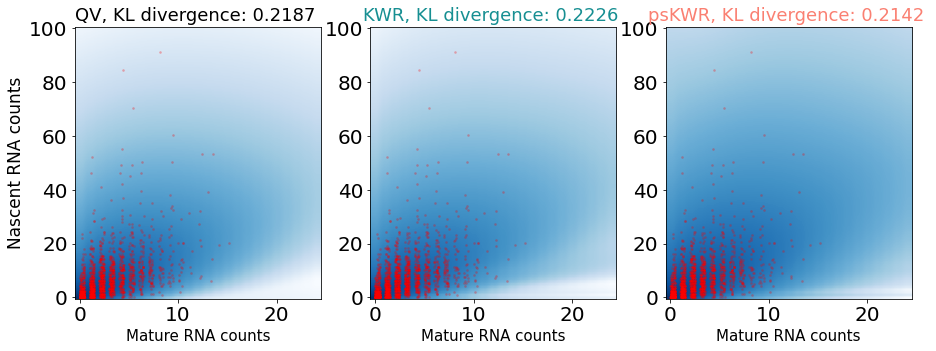

In [79]:

samp = None
gene = 'Rapgef5'
print(gene in gene_names)
i = np.where(gene_names == gene)[0][0]
print(i)

print(search_data.gene_names[i])


cmap = mpl.colormaps['Blues']



fig,ax = plt.subplots(1,3,figsize = (15,5))
lm = search_data.M[:,i]
print(lm)
jitter = np.random.uniform(0, 0.5, size=search_data.layers[:2,i,:].shape)


# plot qv predicted distribution
y = search_data.layers[0,i,:]+jitter[0,:]
x = search_data.layers[1,i,:]+jitter[1,:]
ax[0].scatter(x,y,color='red',s=3,alpha=0.2)
qv_predicted_distribution = fitmodel_qv.eval_model_pss(pars_qv[i], lm)
ax[0].imshow(np.log10(qv_predicted_distribution),cmap = cmap,aspect="auto")
ax[0].invert_yaxis()
kld_ = fitmodel_qv.eval_model_kld(pars_psKWR[i], lm, samp, search_data.hist[i], hist_type="unique", EPS=1e-15)
ax[0].set_title(f'QV, KL divergence: {kld_:.4f} ',fontsize=fontsize)


# plot KWR predicted distribution
ax[1].scatter(x,y,color='red',s=3,alpha=0.2)
KWR_predicted_distribution = fitmodel_KWR.eval_model_pss(pars_KWR[i], lm)
ax[1].imshow(np.log10(KWR_predicted_distribution),cmap =  cmap,aspect="auto")
ax[1].invert_yaxis()
kld_ = fitmodel_KWR.eval_model_kld(pars_psKWR[i], lm, samp, search_data.hist[i], hist_type="unique", EPS=1e-15)
ax[1].set_title(f'KWR, KL divergence: {kld_:.4f} ',fontsize=fontsize, color = color_KWR)


# plot psKWR predicted distribution
ax[2].scatter(x,y,color='red',s=3,alpha=0.2)
psKWR_predicted_distribution = fitmodel_psKWR.eval_model_pss(pars_psKWR[i], lm)
ax[2].imshow(np.log10(psKWR_predicted_distribution),cmap =  cmap,aspect="auto")
ax[2].invert_yaxis()
kld_ = fitmodel_psKWR.eval_model_kld(pars_psKWR[i], lm, samp, search_data.hist[i], hist_type="unique", EPS=1e-15)
ax[2].set_title(f'psKWR, KL divergence: {kld_:.4f} ',fontsize=fontsize, color = color_psKWR)

ax[0].set_ylabel('Nascent RNA counts',fontsize=17)

for k in range(3):
    ax[k].tick_params(labelsize=20)
    ax[k].set_xlabel('Mature RNA counts',fontsize=15)
    
    
    
    
plt.savefig('./rapgef5_monod.png')